# Modelling and Evaluation Notebook

## Objectives 

*   Answer business requirement 2: 
    * The client is interested to tell whether a given leave contains powdery mildews or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings (pickle file).

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation + plotting of augmented images
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments | Insights | Conclusions



# Model A - Import regular packages


In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread


# Set Working Directory

In [67]:
cwd= os.getcwd()

In [68]:
os.chdir('/workspace/PP5')
print("You set a new current directory")

You set a new current directory


In [69]:
work_dir = os.getcwd()
work_dir

'/workspace/PP5'

---

## Set input directories

Set train, validation and test paths

In [70]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [71]:
version = 'v4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [72]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [73]:
## Import saved image shape embedding
import joblib
version = 'v4'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(30, 30, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




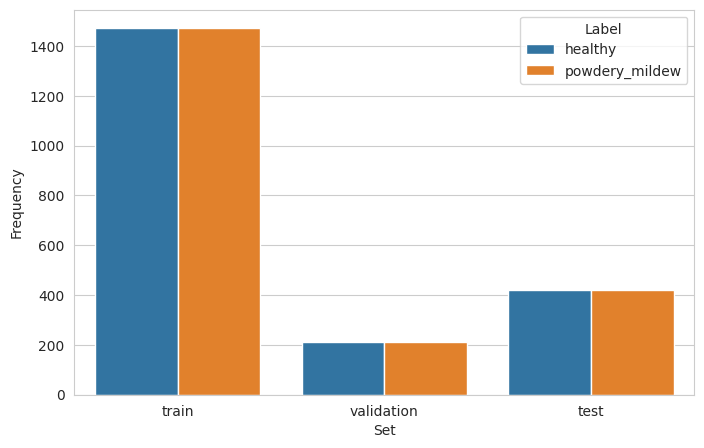

In [75]:
labels = ['healthy', 'powdery_mildew']

# Initialize an empty DataFrame
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Iterate through dataset folders
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = pd.concat([
            df_freq,
            pd.DataFrame({
                'Set': [folder],
                'Label': [label],
                'Frequency': [int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))]
            })
        ], ignore_index=True)

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images"
        )

# Plot the results
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

### ImageDataGenerator

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [42]:
augmented_image_data = ImageDataGenerator(rotation_range=25,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


### Augment training image dataset

In [77]:
batch_size = 25  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [78]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [79]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image

(25, 30, 30, 3)


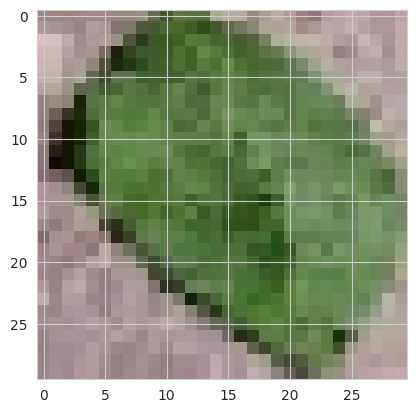

(25, 30, 30, 3)


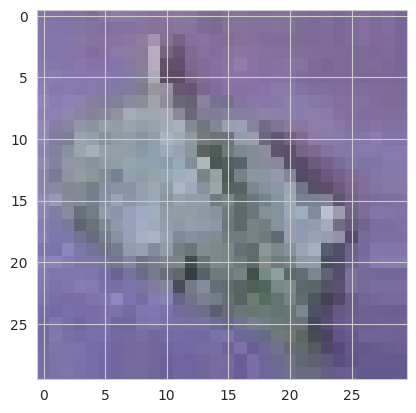

(25, 30, 30, 3)


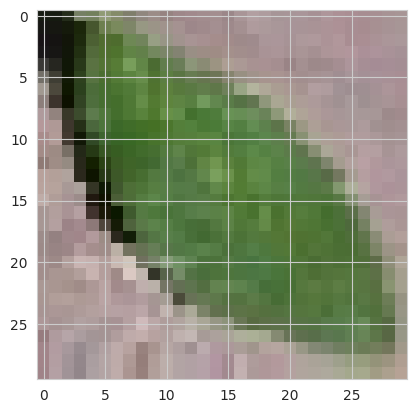

In [80]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


### Plot augmented validation and test images

(25, 30, 30, 3)


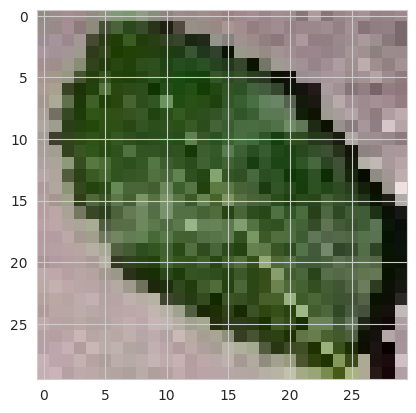

(25, 30, 30, 3)


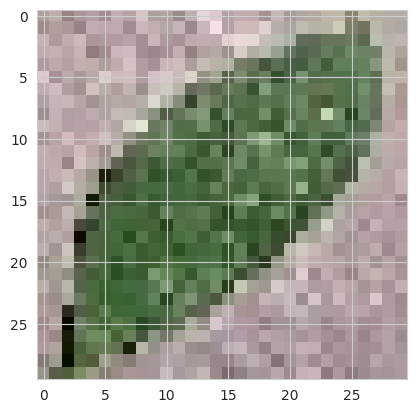

(25, 30, 30, 3)


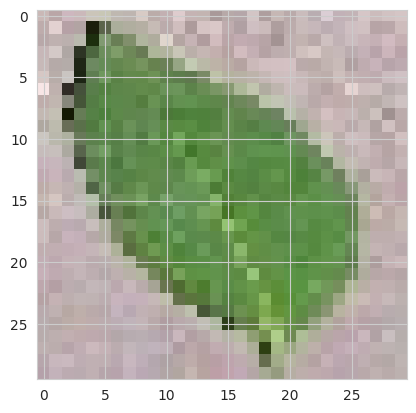

In [81]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(25, 30, 30, 3)


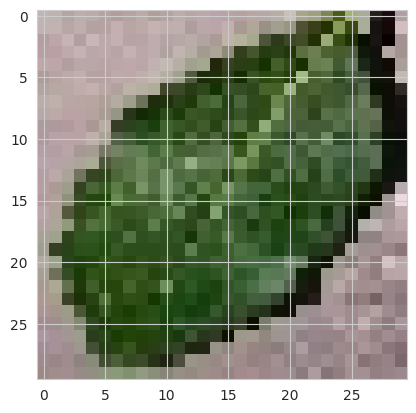

(25, 30, 30, 3)


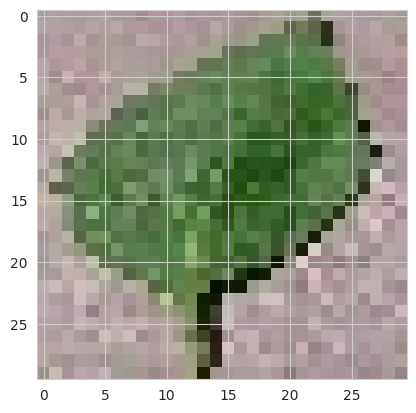

(25, 30, 30, 3)


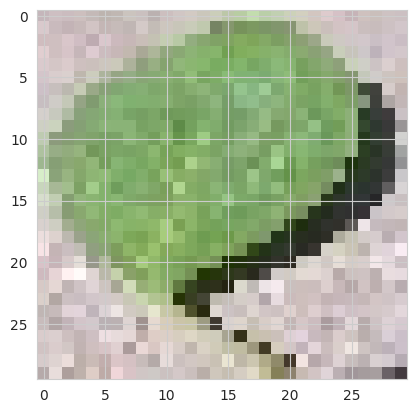

In [82]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [83]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v4/class_indices.pkl']

---

# Model creation

---

## ML model

### Import model packages

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import initializers

 ### Model 

In [85]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=initializers.GlorotUniform(seed=None),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializers.GlorotUniform(seed=None),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Model Summary 

In [86]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 64)        

### Early stopping to reduce risk of overfitting

In [87]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [88]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
117/117 [==============================] - 4s 34ms/step - loss: 0.5291 - accuracy: 0.7146 - val_loss: 0.2380 - val_accuracy: 0.9333
Epoch 2/25
117/117 [==============================] - 4s 32ms/step - loss: 0.2367 - accuracy: 0.9157 - val_loss: 0.0899 - val_accuracy: 0.9690
Epoch 3/25
117/117 [==============================] - 4s 32ms/step - loss: 0.1576 - accuracy: 0.9469 - val_loss: 0.0662 - val_accuracy: 0.9643
Epoch 4/25
117/117 [==============================] - 3s 25ms/step - loss: 0.1468 - accuracy: 0.9510 - val_loss: 0.1460 - val_accuracy: 0.9357
Epoch 5/25
117/117 [==============================] - 3s 21ms/step - loss: 0.1009 - accuracy: 0.9695 - val_loss: 0.0608 - val_accuracy: 0.9833
Epoch 6/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0792 - accuracy: 0.9788 - val_loss: 0.0203 - val_accuracy: 0.9929
Epoch 7/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0624 - accuracy: 0.9822 - val_loss: 0.0182 - val_accuracy: 0.9952

## Save model

In [89]:
model.save('outputs/v4/mildew_detection_model.h5')

---

# Model Performace

---

## Model learning curve

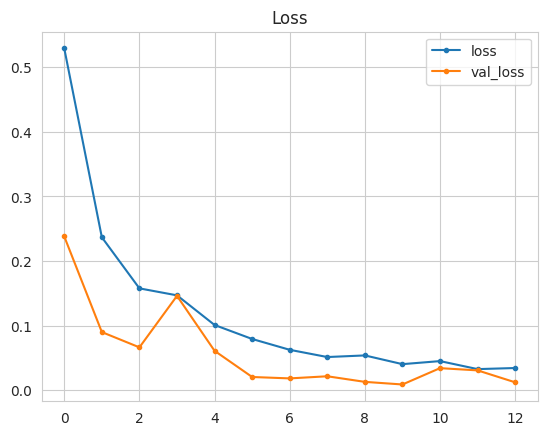

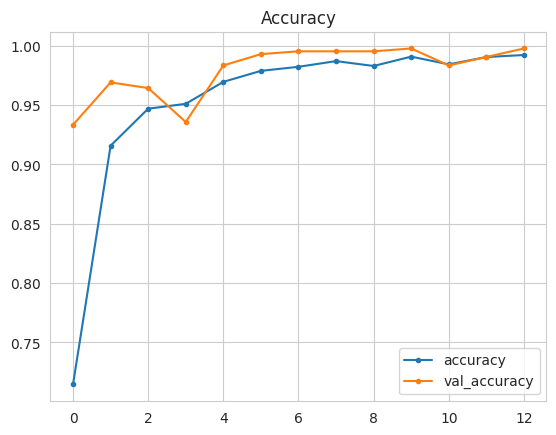

In [90]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [91]:
from keras.models import load_model
model = load_model('outputs/v4/mildew_detection_model.h5')

Evaluate model on test set

In [92]:
evaluation = model.evaluate(test_set)

34/34 [==============================] - 0s 8ms/step - loss: 0.0155 - accuracy: 0.9953


### Save evaluation pickle

In [93]:
joblib.dump(value=evaluation,
            filename=f"outputs/v4/evaluation.pkl")

['outputs/v4/evaluation.pkl']

## Predict on new data

Load a random image 

In [94]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Image shape: (30, 30), Image mode: RGB


Convert image to array and prepare for prediction

In [95]:

my_image = image.img_to_array(pil_image)

my_image = np.expand_dims(my_image, axis=0)/255

print(my_image.shape)

(1, 30, 30, 3)


Predicting the unseen data (healthy)

In [96]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 63ms/step
0.9999876851243243
healthy


Testing again with unseen image (mildew infected)

In [97]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Image shape: (30, 30), Image mode: RGB


Convert image to array and prepare for prediction

In [98]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 30, 30, 3)


Predict class probabilities

In [99]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 16ms/step
0.99986625
powdery_mildew


# Push files to Repo

* .gitignore

In [146]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
*.zip
*.jpg
/inputs/cherryleaves_dataset/cherry-leaves/test/*
/inputs/cherryleaves_dataset/cherry-leaves/train/*
/inputs/cherryleaves_dataset/cherry-leaves/validation/*

inputs/cherryleaves_datasets/cherry-leaves/test/healthy
inputs/cherryleaves_datasets/cherry-leaves/test/powdery_mildew
inputs/cherryleaves_datasets/cherry-leaves/train/healthy
inputs/cherryleaves_datasets/cherry-leaves/train/powdery_mildew
inputs/cherryleaves_datasets/cherry-leaves/validation/powdery_mildew
inputs/cherryleaves_datasets/cherry-leaves/validation/healthy
outputs/v1
/outputs/v1/*
outputs/v2
/outputs/v2/*

README.md
